In [5]:
# import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load data and EDA

In [7]:
def load_libsvm(file_path):
    features = []
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            items = line.strip().split()
            labels.append(float(items[0]))
            feat = np.zeros(8)  # we have 8 features
            for item in items[1:]:
                index, value = item.split(':')
                feat[int(index) - 1] = float(value)
            features.append(feat)
    return np.array(features), np.array(labels)

X, y = load_libsvm('data.txt')

data = np.column_stack((X, y))

df = pd.DataFrame(data, columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'label'])

df.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,label
0,6.0,148.0,72.0,35.0,0.0,33.599998,0.627,50.0,-1.0
1,1.0,85.0,66.0,29.0,0.0,26.600000,0.351,31.0,1.0
2,8.0,183.0,64.0,0.0,0.0,23.299999,0.672,32.0,-1.0
3,1.0,89.0,66.0,23.0,94.0,28.100000,0.167,21.0,1.0
4,0.0,137.0,40.0,35.0,168.0,43.099998,2.288,33.0,-1.0


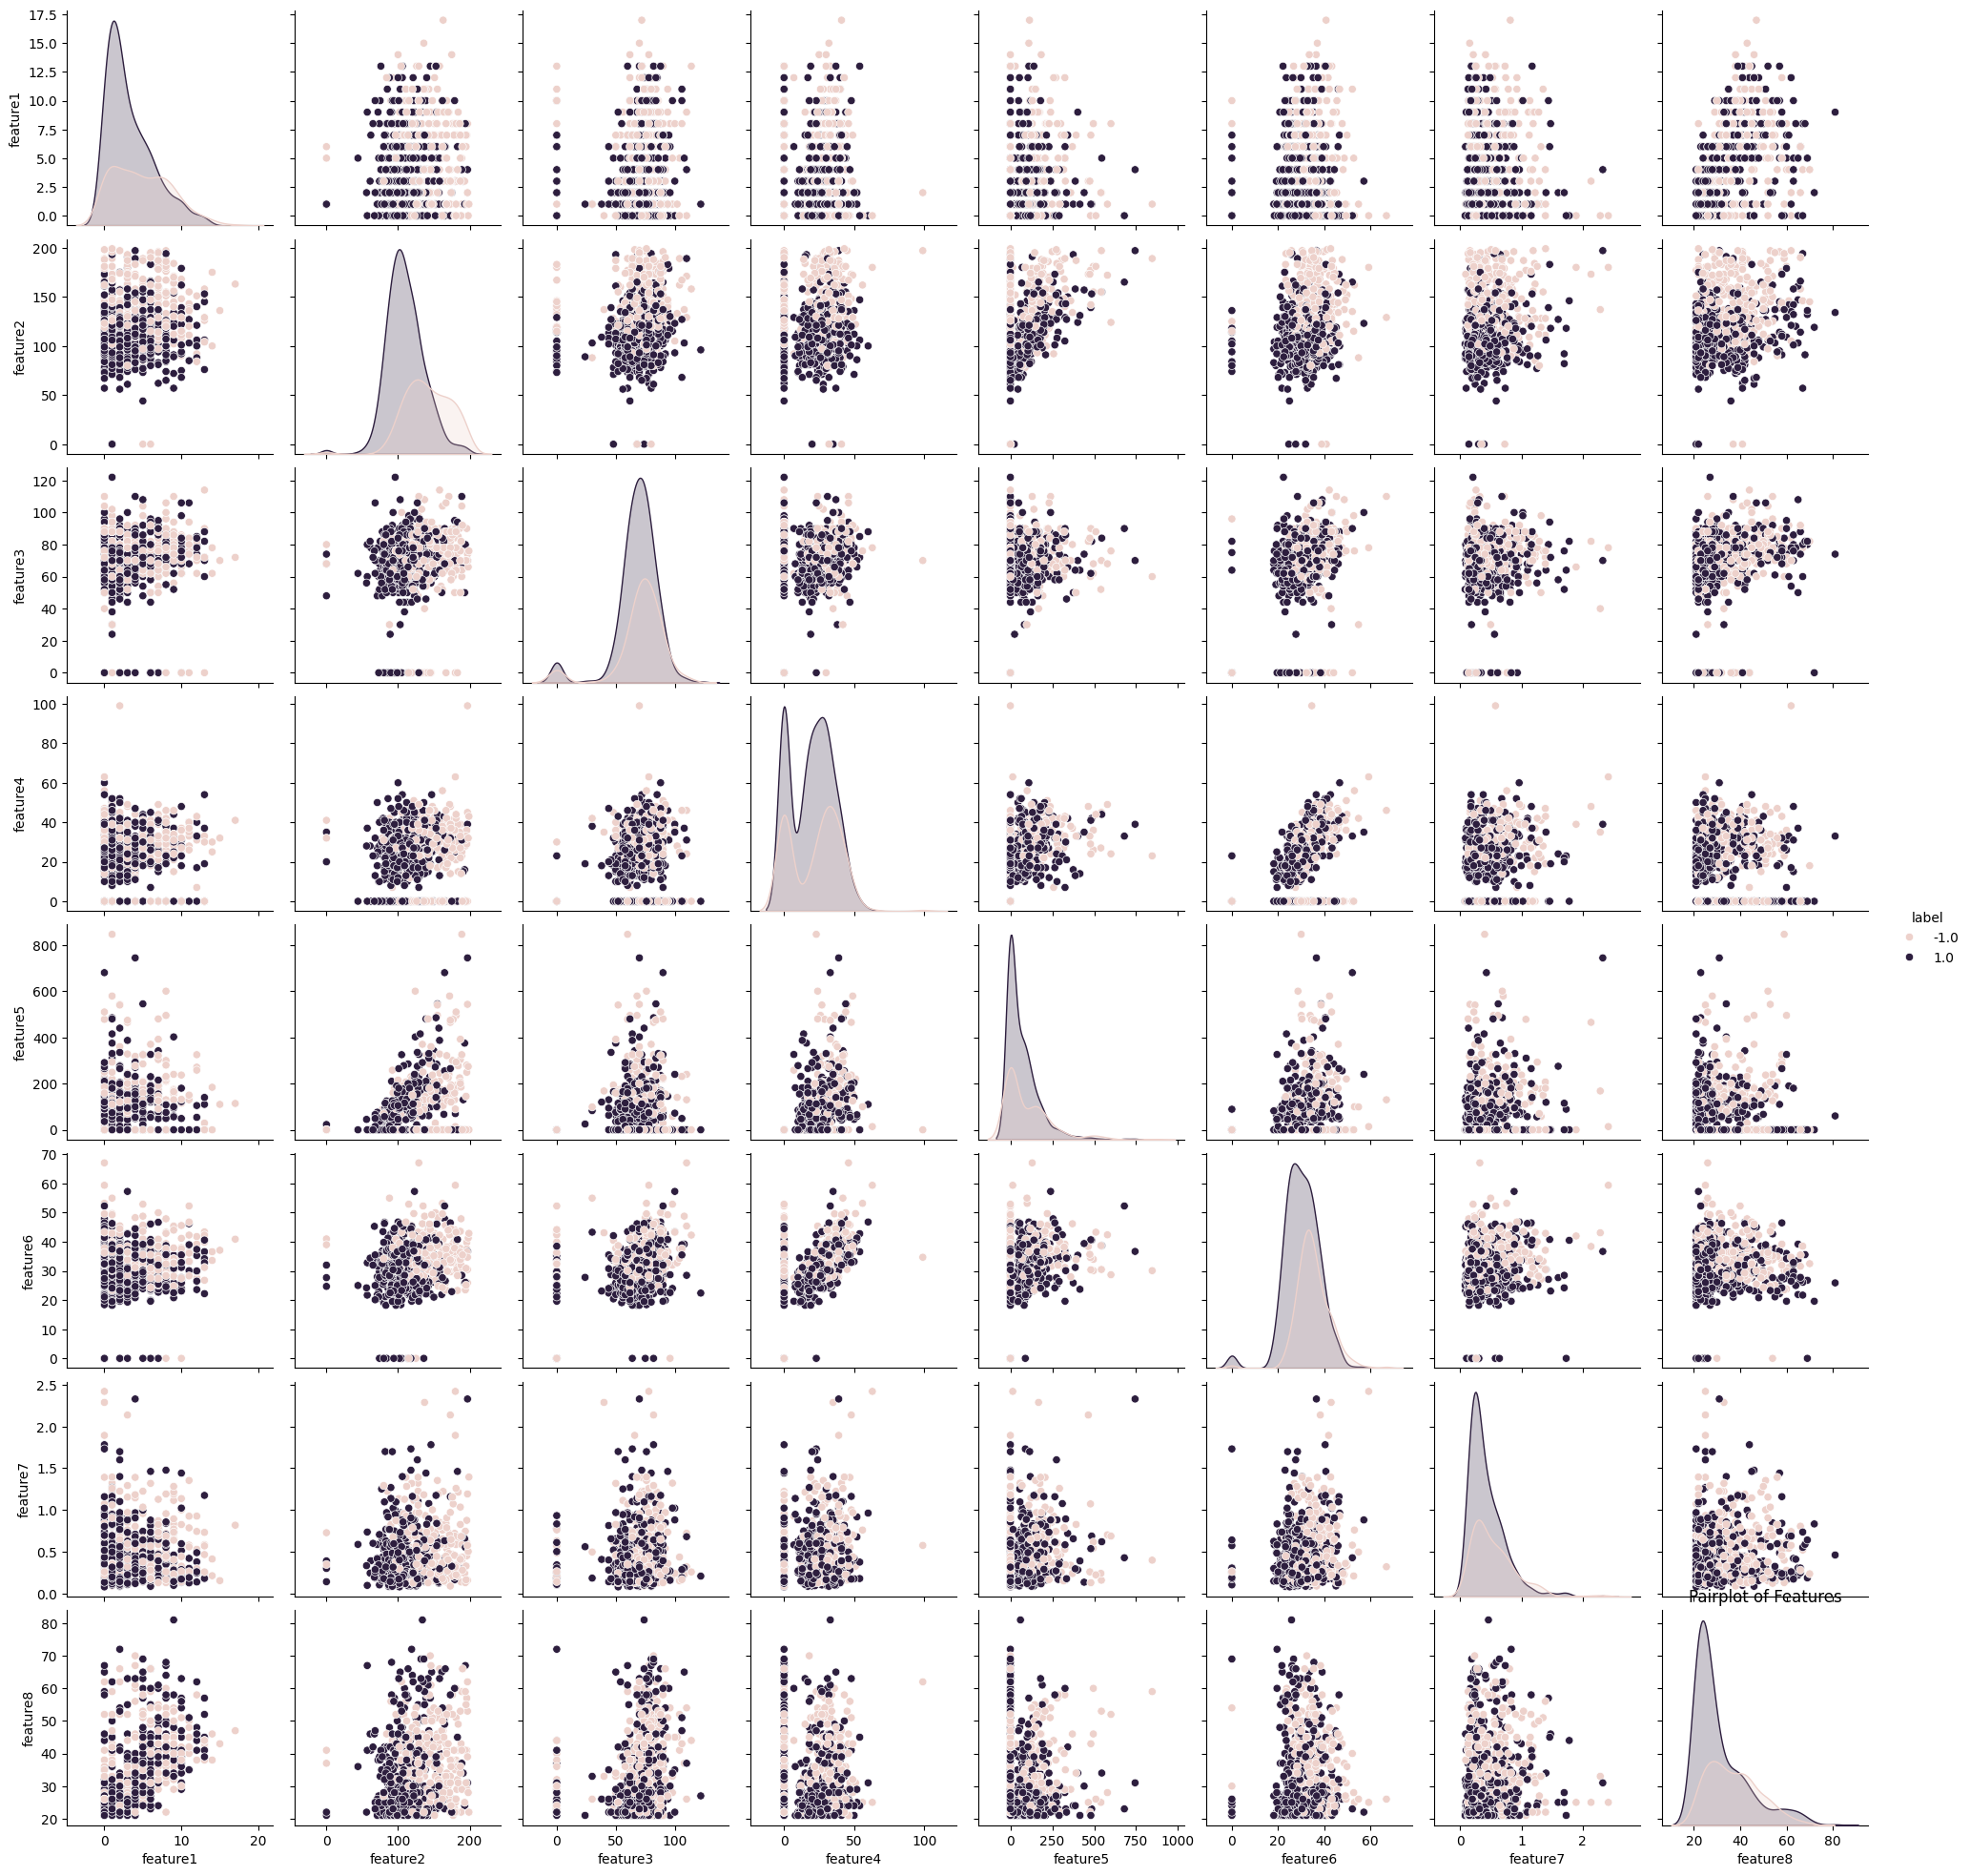

In [8]:
sns.pairplot(df, diag_kind="kde", hue='label')
plt.title('Pairplot of Features')
plt.show()


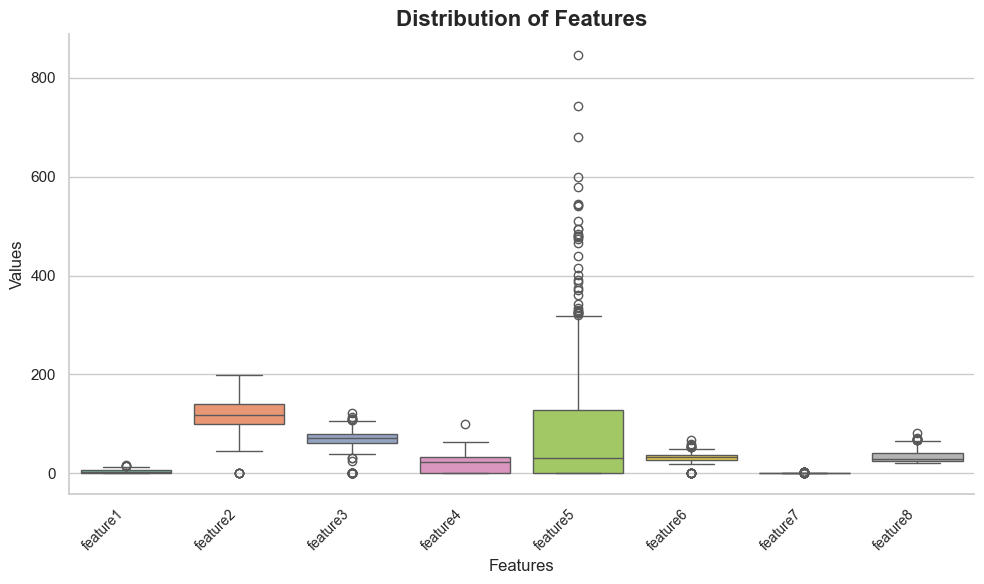

In [9]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

palette = sns.color_palette("Set2")

sns.boxplot(data=df.drop(columns='label'), palette=palette)

plt.title('Distribution of Features', fontsize=16, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Values', fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize=10)

sns.despine()
plt.tight_layout()  
plt.show()


In [10]:
label_counts = df['label'].value_counts()

print(label_counts)

 1.0    500
-1.0    268
Name: label, dtype: int64


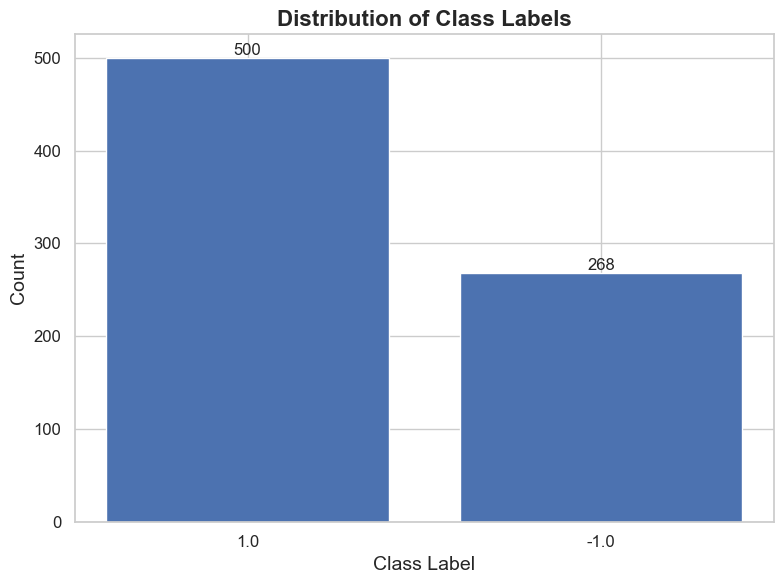

In [11]:

sns.set_palette("deep")

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(label_counts.index.astype(str), label_counts.values)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height}',
            ha='center', va='bottom')

ax.set_title('Distribution of Class Labels', fontsize=16, fontweight='bold')
ax.set_xlabel('Class Label', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Create Perceptron and train the model

In [12]:
# scale data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)


y = np.where(y == 0, -1, y)

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

class Perceptron:
    def __init__(self, input_size, activation='step', learning_rate=0.01, epochs=1000):
        self.weights = np.random.randn(input_size) * 0.01  # random initialize weights
        self.bias = 0
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.activation = activation
        self.set_activation(activation)
    
    def set_activation(self, activation):
        if activation == 'step':
            self.activation_function = lambda x: np.where(x >= 0, 1, -1)
        elif activation == 'sigmoid':
            self.activation_function = lambda x: 1 / (1 + np.exp(np.clip(-x, -500, 500)))
        elif activation == 'relu':
            self.activation_function = lambda x: np.maximum(0, x)
        else:
            raise ValueError("Unsupported activation function")

    def predict(self, inputs):
        summation = np.dot(inputs, self.weights) + self.bias
        activation = self.activation_function(summation)
        if self.activation in ['sigmoid', 'relu']:
            return np.where(activation >= 0.5, 1, -1)
        return activation
    
    def train(self, X, y):
        for _ in range(self.epochs):
            for inputs, label in zip(X, y):
                prediction = self.predict(inputs)
                self.weights += self.learning_rate * (label - prediction) * inputs
                self.bias += self.learning_rate * (label - prediction)

def cross_validation(X, y, activation, k=5):
    fold_size = len(X) // k
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    
    scores = []
    for i in range(k):
        test_start = i * fold_size
        test_end = (i + 1) * fold_size if i < k - 1 else len(X)
        
        test_indices = indices[test_start:test_end]
        train_indices = np.concatenate([indices[:test_start], indices[test_end:]])
        
        X_train_fold, X_val_fold = X[train_indices], X[test_indices]
        y_train_fold, y_val_fold = y[train_indices], y[test_indices]
        
        perceptron = Perceptron(input_size=X.shape[1], activation=activation)
        perceptron.train(X_train_fold, y_train_fold)
        
        predictions = np.array([perceptron.predict(x) for x in X_val_fold])
        accuracy = np.mean(predictions == y_val_fold)
        scores.append(accuracy)
    
    return np.array(scores)


normalized

In [13]:

# cross validation
activations = ['step', 'sigmoid', 'relu']
best_activation = None
best_score = 0

for activation in activations:
    cv_scores = cross_validation(X_train, y_train, activation, k=5)
    mean_score = cv_scores.mean()
    print(f"Activation: {activation}")
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV score: {mean_score:.2f}")
    print(f"Standard deviation of CV scores: {cv_scores.std():.2f}")
    print()
    
    if mean_score > best_score:
        best_score = mean_score
        best_activation = activation

print(f"Best activation function: {best_activation}")

# train final model
final_perceptron = Perceptron(input_size=X_train.shape[1], activation=best_activation)
final_perceptron.train(X_train, y_train)

# evaluate final model
test_predictions = np.array([final_perceptron.predict(x) for x in X_test])
test_accuracy = np.mean(test_predictions == y_test)

print(f"Final Test Accuracy: {test_accuracy:.2f}")

Activation: step
Cross-validation scores: [0.72131148 0.63114754 0.60655738 0.71311475 0.71428571]
Mean CV score: 0.68
Standard deviation of CV scores: 0.05

Activation: sigmoid
Cross-validation scores: [0.68852459 0.71311475 0.72131148 0.74590164 0.65079365]
Mean CV score: 0.70
Standard deviation of CV scores: 0.03

Activation: relu
Cross-validation scores: [0.55737705 0.54918033 0.6147541  0.46721311 0.74603175]
Mean CV score: 0.59
Standard deviation of CV scores: 0.09

Best activation function: sigmoid
Final Test Accuracy: 0.82


unnormalized

In [14]:
# use the unnormalized data to train the model
X_train_unnormalized, X_test_unnormalized, y_train_unnormalized, y_test_unnormalized = train_test_split(X, y, test_size=0.2, random_state=42)

# cross validation
best_activation_unnormalized = None
best_score_unnormalized = 0

for activation in activations:
    cv_scores = cross_validation(X_train_unnormalized, y_train_unnormalized, activation, k=5)
    mean_score = cv_scores.mean()
    print(f"Activation: {activation}")
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV score: {mean_score:.2f}")
    print(f"Standard deviation of CV scores: {cv_scores.std():.2f}")
    print()


# train final model
final_perceptron_unnormalized = Perceptron(input_size=X_train_unnormalized.shape[1])
final_perceptron_unnormalized.train(X_train_unnormalized, y_train_unnormalized)

# evaluate final model
test_predictions_unnormalized = np.array([final_perceptron_unnormalized.predict(x) for x in X_test_unnormalized])
test_accuracy_unnormalized = np.mean(test_predictions_unnormalized == y_test_unnormalized)

print(f"Final Test Accuracy (Unnormalized): {test_accuracy_unnormalized:.2f}")



Activation: step
Cross-validation scores: [0.76229508 0.60655738 0.70491803 0.68032787 0.38888889]
Mean CV score: 0.63
Standard deviation of CV scores: 0.13

Activation: sigmoid
Cross-validation scores: [0.63114754 0.46721311 0.53278689 0.63114754 0.37301587]
Mean CV score: 0.53
Standard deviation of CV scores: 0.10

Activation: relu
Cross-validation scores: [0.68852459 0.66393443 0.75409836 0.59836066 0.5       ]
Mean CV score: 0.64
Standard deviation of CV scores: 0.09

Final Test Accuracy (Unnormalized): 0.71
